In [1]:
%matplotlib inline
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models, transforms
from torch.autograd import Variable
from torch import topk

import src.dataloading as data
from tqdm import tqdm

In [2]:
train_dataloader, valid_dataloader, test_dataloader = data.load_data()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running model on:",device)

model = torchvision.models.resnet50(pretrained=True)
print(model)

Running model on: cuda:0
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel

In [3]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Linear(in_features=2048, out_features=120,bias=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.to(device)
print()

In [4]:
def train(n_epochs=5):
    model.train()
    for epoch in tqdm(range(n_epochs)):
        #train_loss = []
        for data_t, targets_t in train_dataloader:
            data_t = data_t.to(device)
            targets_t = targets_t.to(device)
            optimizer.zero_grad()
            # Generate predictions
            out = model(data_t)
            # Calculate loss
            loss = criterion(out, targets_t)
            #train_loss.append(loss.item())
            # Backpropagation
            loss.backward()
            # Update model parameters
            optimizer.step()
        #print("Loss: ",np.average(train_loss))

In [5]:
train(10)

100%|██████████| 10/10 [08:57<00:00, 53.76s/it]


In [7]:
train(10)
torch.save(model,"model/m20.pt")

100%|██████████| 10/10 [09:01<00:00, 54.18s/it]


FileNotFoundError: [Errno 2] No such file or directory: 'model/m20.pt'

In [9]:
from PIL import Image
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

final_layer = model._modules.get('layer4')
fb = SaveFeatures(final_layer)

In [10]:
# Data pre-process.
transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])


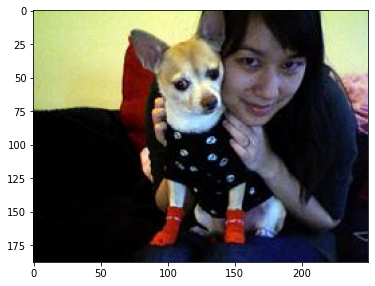

In [11]:
# Example picture.
plt.figure(figsize=(6, 6))
img = Image.open("Images/n02085620-Chihuahua/n02085620_7.jpg").convert("RGB")
plt.imshow(img)
plt.show()

In [12]:
# Prepare input.
input_tensor = transform(img).unsqueeze(0).cuda()

# Model in evaluation mode.
model = model.eval()

# Get probabilities and feature maps.
out = model(input_tensor)
feature_maps = fb.features

# 120 classes, and 2048xWxH feature maps ((W,H)depend on image's size after pre-processing).
print("Output's shape: ", out.shape)
print("Feature maps's shape: ", feature_maps.shape)

Output's shape:  torch.Size([1, 120])
Feature maps's shape:  torch.Size([1, 2048, 7, 10])


In [13]:
#Get probs from output as torchvision models do not have this final layer.
# If you do not care about the score, then you only need to find the max and ommit this line :).
probs = torch.nn.functional.softmax(out[0], dim=0)

# Find out which class image belongs.
score, _class = torch.max(probs, dim=0)
print("Score: ", score.item(), " Class: ", _class.item())

Score:  0.5887362957000732  Class:  0


In [14]:


# Get weights and biases for fully conected linear layer.
weights_and_biases = list(model._modules.get('fc').parameters())
print("Weights's shape: ", weights_and_biases[0].shape)
print("Biases's shape: ", weights_and_biases[1].shape)

# Get weights for the class's neuron.
class_weights = weights_and_biases[0][_class]
print("Class weights's shape :", class_weights.shape)



Weights's shape:  torch.Size([120, 2048])
Biases's shape:  torch.Size([120])
Class weights's shape : torch.Size([2048])


In [15]:


# Weights must be reshaped to match feature maps's dimension.
class_weights = class_weights.reshape((-1, 1, 1))
print("Class weights's shape :", class_weights.shape)

# We can also reduce one empty dimension (first one) of the feature maps.
feature_maps = feature_maps.flatten(start_dim=0, end_dim=1)
print("Feature maps's shape: ", feature_maps.shape)



Class weights's shape : torch.Size([2048, 1, 1])
Feature maps's shape:  torch.Size([2048, 7, 10])


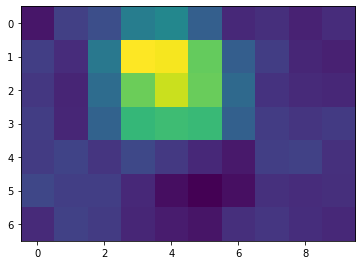

In [17]:
# Get class_activation maps
class_activation_maps = np.array(torch.sum(feature_maps * class_weights, dim=0).detach().cpu(), dtype=np.float32)
plt.figure(figsize=(6, 6))
plt.imshow(class_activation_maps)
plt.show()

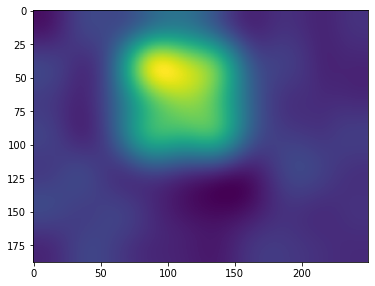

In [18]:
# Resize tensor to match original image's size.
resized_cam = cv2.resize(class_activation_maps, dsize=img.size, interpolation=cv2.INTER_LANCZOS4)
plt.figure(figsize=(6, 6))
plt.imshow(resized_cam)
plt.show()

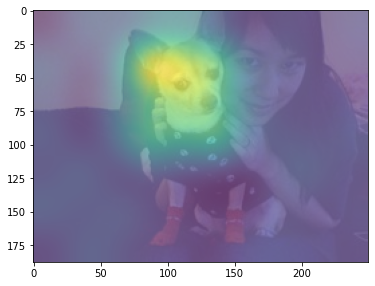

In [19]:


# Visualization of the class activation map, over the original image.
plt.figure(figsize=(6, 6))
plt.imshow(img, alpha=0.4)
plt.imshow(resized_cam, alpha=0.6)
plt.show()



In [26]:
def getCAM(img, model=None):
    assert(model != None)
    input_tensor = transform(img).unsqueeze(0).to(device)
    model = model.eval()
    out = model(input_tensor)
    probs = torch.nn.functional.softmax(out[0], dim=0)
    score, _class = torch.max(probs, dim=0)
    print("Score: ", score.item(), " Class: ", _class.item())
    feature_maps = fb.features
    weights_and_biases = list(model._modules.get('fc').parameters())
    class_weights = weights_and_biases[0][_class]
    class_weights = class_weights.reshape((-1, 1, 1))
    feature_maps = feature_maps.flatten(start_dim=0, end_dim=1)
    class_activation_maps = np.array(torch.sum(feature_maps * class_weights, dim=0).detach().cpu(), dtype=np.float32)
    resized_cam = cv2.resize(class_activation_maps, dsize=img.size, interpolation=cv2.INTER_LANCZOS4)
    plt.figure(figsize=(6, 6))
    plt.imshow(img, alpha=0.4)
    plt.imshow(resized_cam, alpha=0.6)
    return plt

Score:  0.5996954441070557  Class:  40


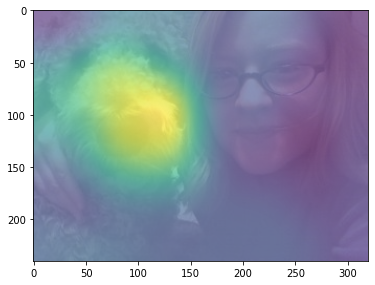

In [30]:
image = Image.open("Images/n02096051-Airedale/n02096051_4991.jpg").convert("RGB")
getCAM(image,model).show()

Score:  0.6609952449798584  Class:  11


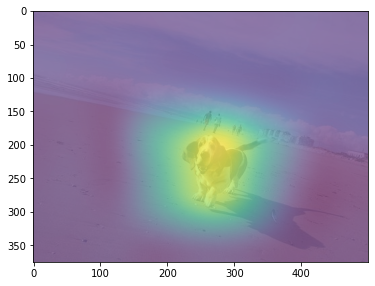

In [29]:
image = Image.open("Images/n02088238-basset/n02088238_3079.jpg").convert("RGB")
getCAM(image,model).show()